In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
import fastdtw as fastdtw
from tslearn.utils import to_time_series_dataset

In [2]:
def load_npy(filename):
    return np.load(filename)


dir_path = 'cleaned_time_series/'
len_threshold = 1280
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0])  # track_id
    y.append(split[1][:-4])  # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)
print(len(X))

10000


In [3]:
from pyts.approximation import paa as paa

# Initialize PAA transformer
approximator = paa.PiecewiseAggregateApproximation(window_size=4)

# Apply PAA to your time series data
X_paa = approximator.transform(X.reshape(-1, 1280))

print(X_paa.shape)

(10000, 320)


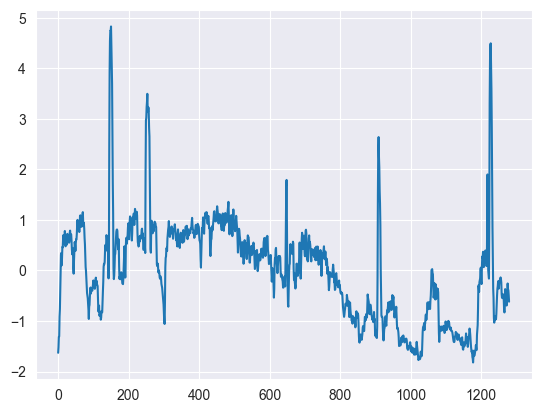

In [89]:
# plot first ts before paa
plt.plot(X[0].reshape(-1))
plt.show()

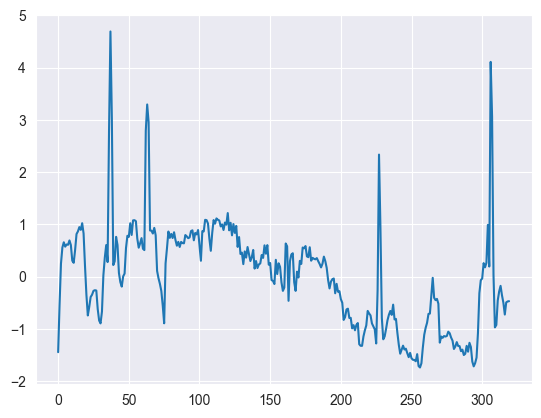

In [90]:
# plot first ts after paa
plt.plot(X_paa[0].reshape(-1))
plt.show()

In [91]:
# Encode the class labels as integers
y = LabelEncoder().fit_transform(y)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X_paa.reshape(-1,1,320), y, test_size=0.8, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2000, 1, 320), (8000, 1, 320), (2000,), (8000,))

In [105]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN with DTW

In [19]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

knn = KNeighborsTimeSeriesClassifier(n_neighbors=9, distance="dtw", n_jobs=-1)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
print(f'Accuracy score:{accuracy_score(y_test, y_pred)}')

Accuracy score:0.05 for n_neighbors=1
Accuracy score:0.15 for n_neighbors=2
Accuracy score:0.1 for n_neighbors=3
Accuracy score:0.1 for n_neighbors=4
Accuracy score:0.05 for n_neighbors=5
Accuracy score:0.1 for n_neighbors=6
Accuracy score:0.05 for n_neighbors=7
Accuracy score:0.0 for n_neighbors=8
Accuracy score:0.0 for n_neighbors=9
Accuracy score:0.05 for n_neighbors=10
0.2
CPU times: user 41.5 s, sys: 2.14 s, total: 43.6 s
Wall time: 44.4 s


# Shapelets

In [4]:
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.preprocessing import LabelEncoder
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.metrics import classification_report

Shapelets are subsequences that can be used to represent a class. Matrix profiles make it possibile to identify these shapelets.


In [106]:
st = ShapeletTransformClassifier()

In [107]:
%%time
st.fit(X_train_scaled, y_train)
y_pred = st.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

In [108]:
rst = RandomShapeletTransform(n_shapelet_samples=4000, max_shapelets=1, min_shapelet_length=5, max_shapelet_length=20, n_jobs=-1) #n_jobs -1 uses all processors

In [109]:
%%time
rst.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [15]:
%%time
shapelets_distances_train = rst.transform(X_train_scaled[:50])
shapelets_distances_test = rst.transform(X_test_scaled[:50])

CPU times: user 2.62 s, sys: 133 ms, total: 2.76 s
Wall time: 3.51 s


In [19]:
dt = DecisionTreeClassifier()
dt.fit(shapelets_distances_train, y_train[:50])
y_pred = dt.predict(shapelets_distances_test)
print(classification_report(y_test[:50], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2
           4       0.33      0.25      0.29         4
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         0
           9       0.17      0.33      0.22         3
          10       0.00      0.00      0.00         4
          11       0.22      0.50      0.31         4
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         3
          18       0.00    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

# Shapelets with tslearn

In [5]:
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

In [9]:
# I need to convert the data genres in y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 1, 1280), (2000, 1, 1280), (8000,), (2000,))

In [11]:
# Adapt X to tslearn format
X_train = to_time_series_dataset(X_train)
X_test = to_time_series_dataset(X_test)

In [12]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train_scaled.shape, X_test_scaled.shape

((8000, 1, 1280), (2000, 1, 1280))

In [14]:
# To work with the tslearn library, we need to reshape the data where the first dimension is the number of time series, the second dimension is the number of points in each time series, and the third dimension is the number of dimensions (in this case, 1 since we have univariate time series).
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[2], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2], 1)

X_train_scaled.shape, X_test_scaled.shape

((8000, 1280, 1), (2000, 1280, 1))

In [17]:
adam = Adam(learning_rate=0.001)

In [ ]:
%%time
# We will extract 1 shapelet and align it with a time series
shapelet_sizes = {30: 800}

# Define the model and fit it using the training data
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            weight_regularizer=0.001,
                            optimizer=adam,
                            max_iter=100,
                            verbose=1,
                            scale=False,
                            random_state=42)
shp_clf.fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - categorical_accuracy: 0.0636 - categorical_crossentropy: 2.9847 - loss: 3.0214
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step - categorical_accuracy: 0.0864 - categorical_crossentropy: 2.9245 - loss: 2.9547
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - categorical_accuracy: 0.1044 - categorical_crossentropy: 2.8867 - loss: 2.9135
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - categorical_accuracy: 0.1062 - categorical_crossentropy: 2.8554 - loss: 2.8813
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - categorical_accuracy: 0.1170 - categorical_crossentropy: 2.8334 - loss: 2.8592
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step - categorical_accuracy: 0.1208 - categorical_crossentropy: 2.8192 - loss: 2.8448
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - categorical_accuracy: 0.1263 - categorical_crossentropy: 2.8071 - loss: 2.8325
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 270ms/step - catego

In [256]:
# Get the number of extracted shapelets, the (minimal) distances from
# each of the timeseries to each of the shapelets, and the corresponding
# locations (index) where the minimal distance was found
n_shapelets = sum(shapelet_sizes.values())
distances = shp_clf.transform(X_train_scaled)
predicted_locations = shp_clf.locate(X_train_scaled)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step


In [257]:
n_shapelets

800

In [247]:
distances

array([[0.83147275, 0.37232405, 1.924702  , ..., 1.6799047 , 0.3812535 ,
        1.4477259 ],
       [0.41840056, 0.93235844, 1.0636133 , ..., 1.5543329 , 0.53848934,
        0.90143704],
       [0.72134614, 0.64371705, 1.2421652 , ..., 2.1640646 , 0.6046005 ,
        1.34901   ],
       ...,
       [0.9286187 , 0.71414745, 1.8055307 , ..., 0.7255206 , 0.3437207 ,
        1.7110286 ],
       [0.5768188 , 0.71856964, 1.126515  , ..., 0.8769757 , 0.4703958 ,
        1.4259578 ],
       [0.912211  , 1.0772334 , 1.4243453 , ..., 0.8997607 , 0.53984314,
        1.8608956 ]], dtype=float32)

In [248]:
predicted_locations

array([[ 358,  702,  399, ...,  402, 1110,  581],
       [1064,   44,   90, ...,  532,  867,   98],
       [ 870,  261,  739, ..., 1018,  321,   26],
       ...,
       [ 703,  801, 1168, ..., 1171,  255,  624],
       [ 798, 1193,  440, ...,  591,  289,  103],
       [ 989, 1230,  644, ...,  970,  565,  812]])

In [249]:
# We can extract the shapelets from the model
shapelets = shp_clf.shapelets_
shapelets

array([array([[ 1.8826896 ],
              [ 2.60650945],
              [ 2.75284076],
              [ 2.96035624],
              [ 2.85561728],
              [ 2.47496533],
              [ 2.21934319],
              [ 1.82377613],
              [ 1.3913554 ],
              [ 1.32129431],
              [ 1.02237809],
              [ 0.5040071 ],
              [ 0.47453901],
              [ 0.67872661],
              [ 0.86634797],
              [ 0.71827859],
              [-0.19769825],
              [-0.4124614 ],
              [ 0.6878593 ],
              [ 1.45155108],
              [ 1.38882494],
              [ 0.50690305],
              [ 0.26886284],
              [ 0.44621441],
              [ 0.40317121],
              [ 0.55431324],
              [ 1.33759773],
              [ 1.65675318],
              [ 1.77707016],
              [ 1.77768457],
              [ 1.80627894],
              [ 1.08777225],
              [ 1.07931948],
              [ 1.60397649],
              

In [250]:
# Try to predict the class of the time series
shp_clf.predict(X_test_scaled[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


array([ 8, 15,  3,  6, 15])

In [251]:
# reshape y_test (1, 2000, 1) to (2000, 1)
y_test = y_test.reshape(y_test.shape[1], y_test.shape[0])

IndexError: tuple index out of range

VEDIAMO I VARI PARAMETRI
- 50 con 1 -> 0.1 with 500 iter
- 50 con 200 -> 0.34 with 500 iter (tempo esex 50min)
- 50 con 800 -> 0.34 with 1000 iter (tempo esex 2h 30min)
- 100 con 200 -> 0.231 with 100 iter (tempo esex 7min)

In [266]:
# Check if the predictions are correct
shp_clf.score(X_test_scaled, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


0.231

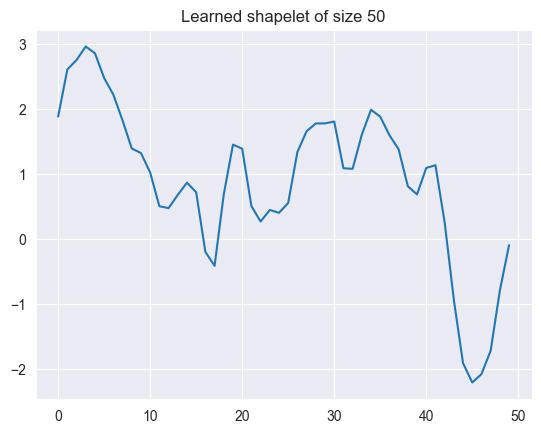

In [262]:
# Plot the shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.title("Learned shapelet of size %d" % sz)
    plt.plot(shapelets[i].ravel())
plt.show()

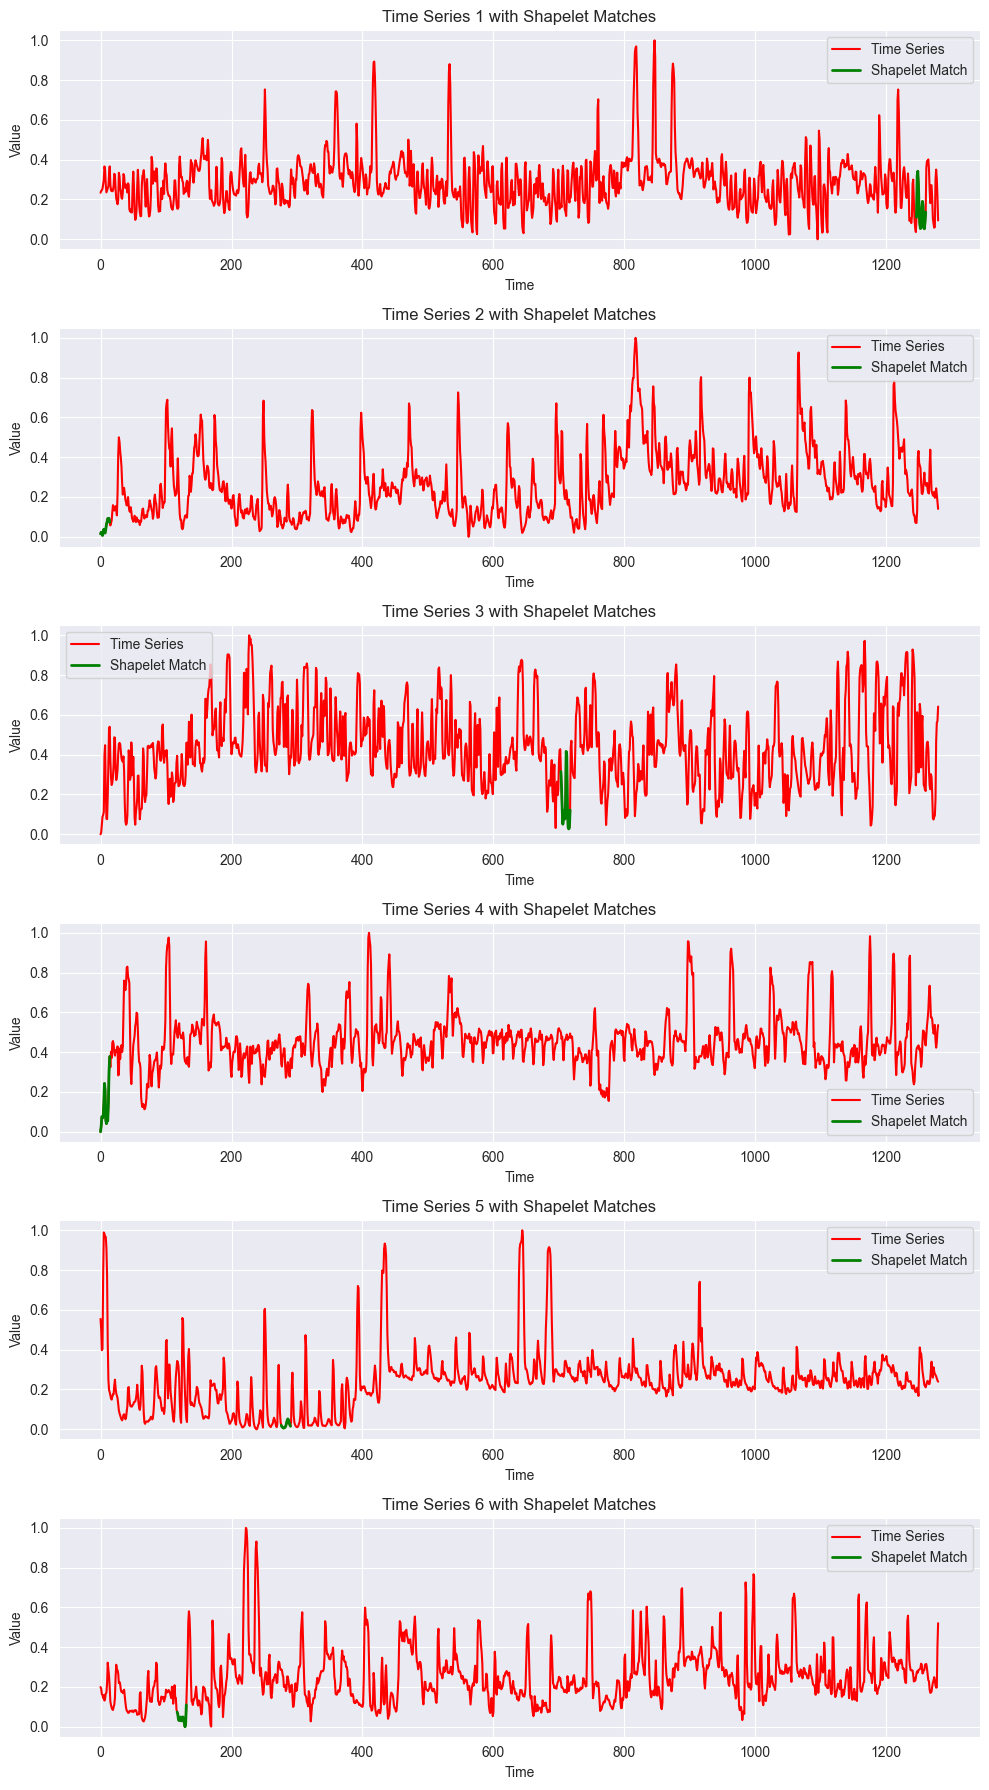

In [188]:
num_instances = 6

# Set up the figure and subplots
fig, axs = plt.subplots(num_instances, 1, figsize=(10, num_instances * 3))

# Iterate through each instance and corresponding axes
for idx, ax in enumerate(axs):
    # Plot the time series
    ax.plot(X_train_scaled[idx].ravel(), "r-", label='Time Series')

    # Find and plot each shapelet
    for shp_idx, shp in enumerate(shapelets):
        # Get the start position of this shapelet in the time series
        start_pos = predicted_locations[idx, shp_idx]

        if start_pos != -1:  # Only plot if the shapelet matches the time series
            # Extract the segment of the time series where the shapelet matches
            matched_segment = X_train_scaled[idx, start_pos:start_pos + len(shp)].ravel()
            ax.plot(range(start_pos, start_pos + len(shp)), matched_segment, "g-", linewidth=2, label='Shapelet Match' if shp_idx == 0 else "")



    # Enhance plot
    ax.legend()
    ax.set_title(f"Time Series {idx + 1} with Shapelet Matches")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()